In [40]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
from plottr.data.datadict_storage import search_datadict
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import copy
import itertools
# import scqubits as scq
import csv
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from lmfit import Model
from setup_td import *

In [41]:
basedir = r"D:/Redza/Logs"

def Fido(datetime, name):          #Fido gets your raw data for you!
    foldername, datadict = search_datadict(basedir, datetime, name=name , newest = True, only_complete=False)
    print(foldername)
    print(datadict)
    return foldername, datadict

In [42]:
foldernamePhoton, datadict_Photon = Fido("2025-05-30T142651","td_2photon_electricfieldcheck_JPACheck_delayedDrive")

#Defining variables
signal = datadict_Photon['waveform']['values'][0]
# freq = datadict_Photon['frequency']['values'][0]*1e-9
time= datadict_Photon["time"]["values"][0]*1e-9
# print(type(signal))

2025-05-30T142651_b0d6d067-td_2photon_electricfieldcheck_JPACheck_delayedDrive
g_minus_e_I (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)
g_minus_e_Q (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)
g_plus_e_I (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)
g_plus_e_Q (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)
wave_I (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)
wave_Q (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)
waveform (V): (1, 3000)
  ⌙ emission_frequency (GHz): (1,)
  ⌙ time (ns): (1, 3000)


[-1.19860683e-06  4.86410108e-06  4.68051698e-06 ...  2.00812555e-06
  2.56581317e-06 -1.47790460e-06]


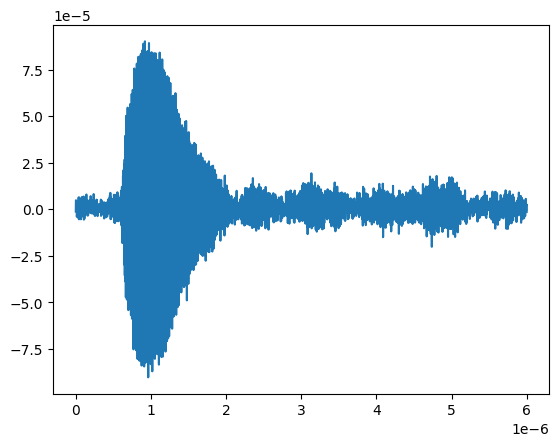

In [43]:
print(signal)
fig, ax = plt.subplots()

ax.plot(time, signal)

plt.show()

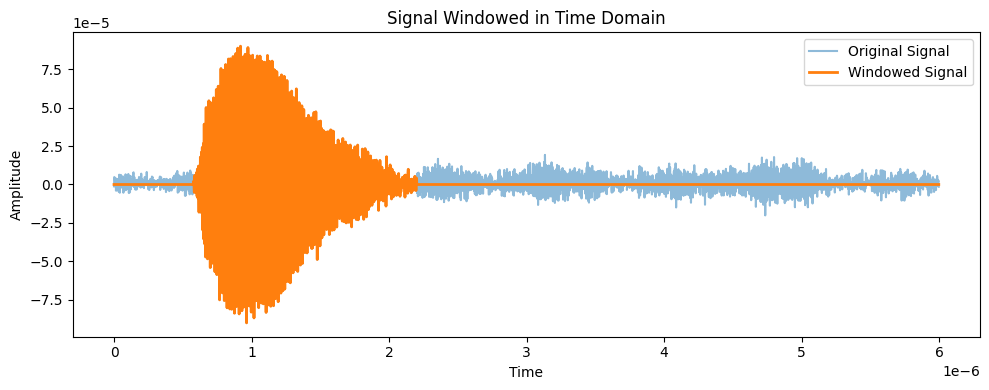

In [44]:
#limiting the waveform to only a section of the time

# time and signal are 1D arrays of the same length

t_start = 5.8e-7  # set your desired time range
t_end = 2.2e-6

# Create a mask: True where time is in [t_start, t_end]
mask = (time >= t_start) & (time <= t_end)

# Apply mask to signal: keep values where mask is True, zero elsewhere
# filtered_signal = np.where(mask, signal, 0)

og_signal = signal
signal = np.where(mask, signal, 0)

plt.figure(figsize=(10, 4))
plt.plot(time, og_signal, label='Original Signal', alpha=0.5)
plt.plot(time, signal, label='Windowed Signal', linewidth=2)
plt.title('Signal Windowed in Time Domain')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()



Defining the Fourier transform

In [45]:
def fourier_tr(x,y, sort=False):
    off_ini = np.mean(y)
    y_mod = y - off_ini
    N = len(y)
    x_fft = np.fft.fftfreq(N,d=x[1]-x[0])
    y_fft = np.fft.fft(y_mod)
    if sort:
        sorted_idx = np.argsort(x_fft)
        x_fft = x_fft[sorted_idx]
        y_fft = y_fft[sorted_idx]
    return x_fft,y_fft

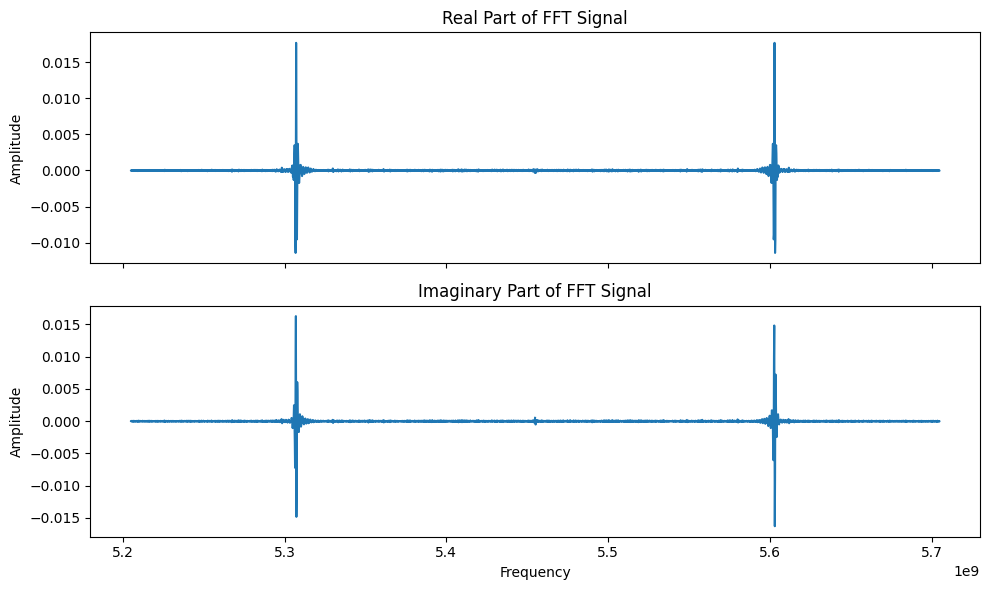

In [46]:
fft_time, fft_signal = fourier_tr(time, signal)
fft_time = fft_time + readout_lo_freq*1e9           #Shifting according to the demodulation frequency
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot real part
axs[0].plot(fft_time, np.real(fft_signal))
axs[0].set_title('Real Part of FFT Signal')
axs[0].set_ylabel('Amplitude')

# Plot imaginary part
axs[1].plot(fft_time, np.imag(fft_signal))
axs[1].set_title('Imaginary Part of FFT Signal')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

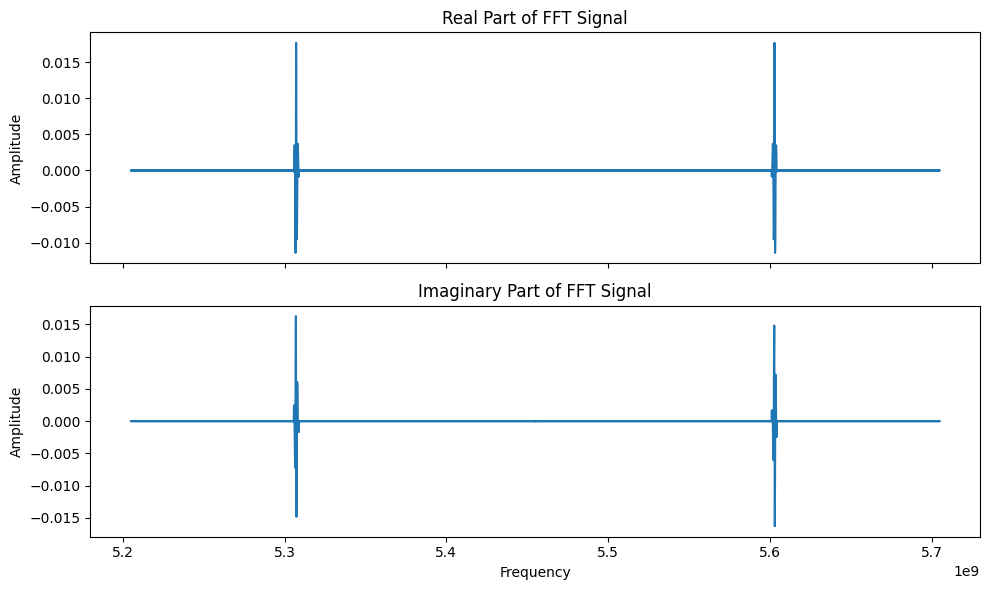

In [47]:
#fourier cleanup!

#filter function
def peak_filter(signal, threshold_coefficient):
    threshold = threshold_coefficient * np.max(np.abs(signal))  # or set manually
    filtered_fft_signal = np.where(np.abs(signal) > threshold, signal, 0)

    return filtered_fft_signal

fft_signal = peak_filter(fft_signal, 0.1)


fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot real part
axs[0].plot(fft_time, np.real(fft_signal))
axs[0].set_title('Real Part of FFT Signal')
axs[0].set_ylabel('Amplitude')

# Plot imaginary part
axs[1].plot(fft_time, np.imag(fft_signal))
axs[1].set_title('Imaginary Part of FFT Signal')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


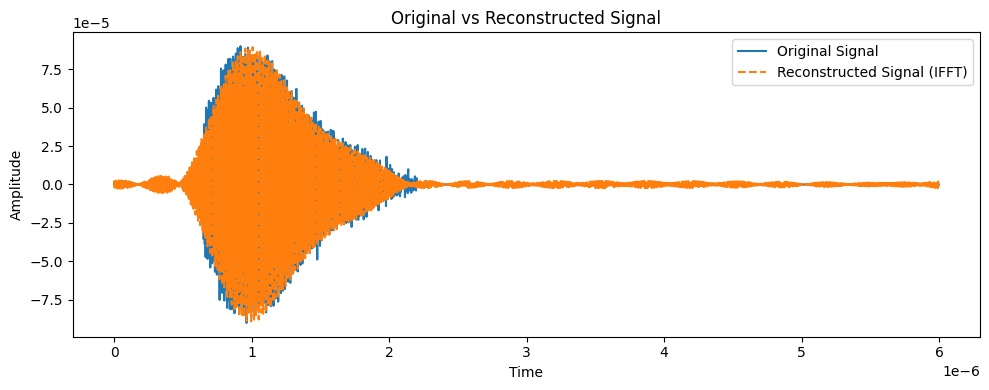

In [48]:
#Inverse Fourier

# Perform inverse Fourier transform
reconstructed_signal = np.fft.ifft(fft_signal)

# Reconstructed signal is complex; take the real part if expected
reconstructed_signal = np.real(reconstructed_signal)

plt.figure(figsize=(10, 4))
plt.plot(time, signal, label='Original Signal')
plt.plot(time, reconstructed_signal, '--', label='Reconstructed Signal (IFFT)')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


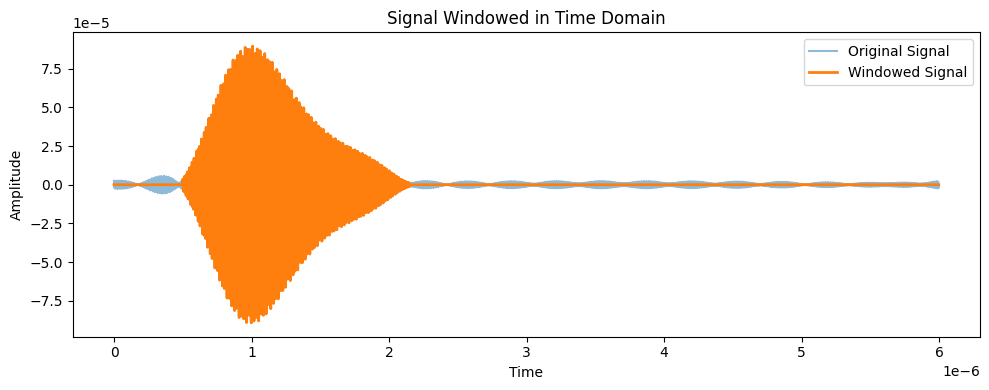

In [57]:
# removing points outside pulse
#limiting the waveform to only a section of the time

# time and signal are 1D arrays of the same length

t_start = 5.e-7  # set your desired time range
t_end = 2.15e-6

# Create a mask: True where time is in [t_start, t_end]
mask = (time >= t_start) & (time <= t_end)

# Apply mask to signal: keep values where mask is True, zero elsewhere
# filtered_signal = np.where(mask, signal, 0)

og_signal = reconstructed_signal
signal = np.where(mask, reconstructed_signal, 0)


plt.figure(figsize=(10, 4))
plt.plot(time, og_signal, label='Original Signal', alpha=0.5)
plt.plot(time, signal, label='Windowed Signal', linewidth=2)
plt.title('Signal Windowed in Time Domain')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
#lastly, putting the waveform into an array

